## 1. 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


## 2. 데이터 불러오기

### 데이터 설명
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

### 변수 설명

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

### csv파일 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']
sub_id = sub["id"]
del data['price']

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0).reset_index().drop(columns=["index", "id"])
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 훑어보기

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_l

In [7]:
data.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


앞으로의 전처리 과정을 정리하겠습니다.
1. 결측값이 존재하는지 확인하고 존재하면 결측값을 제거하겠습니다.
2. date변수를 년월 데이터로 변환하겠습니다.
3. 침실 수, 화장실 수를 합쳐서 방의 수라는 새로운 변수로 만들어보겠습니다.  
4. 연속형 변수들은 표준화(Standard scaling)을 해주겠습니다.

## 3. 데이터 전처리및 시각화

### 1. 결측값 확인하기

<AxesSubplot:>

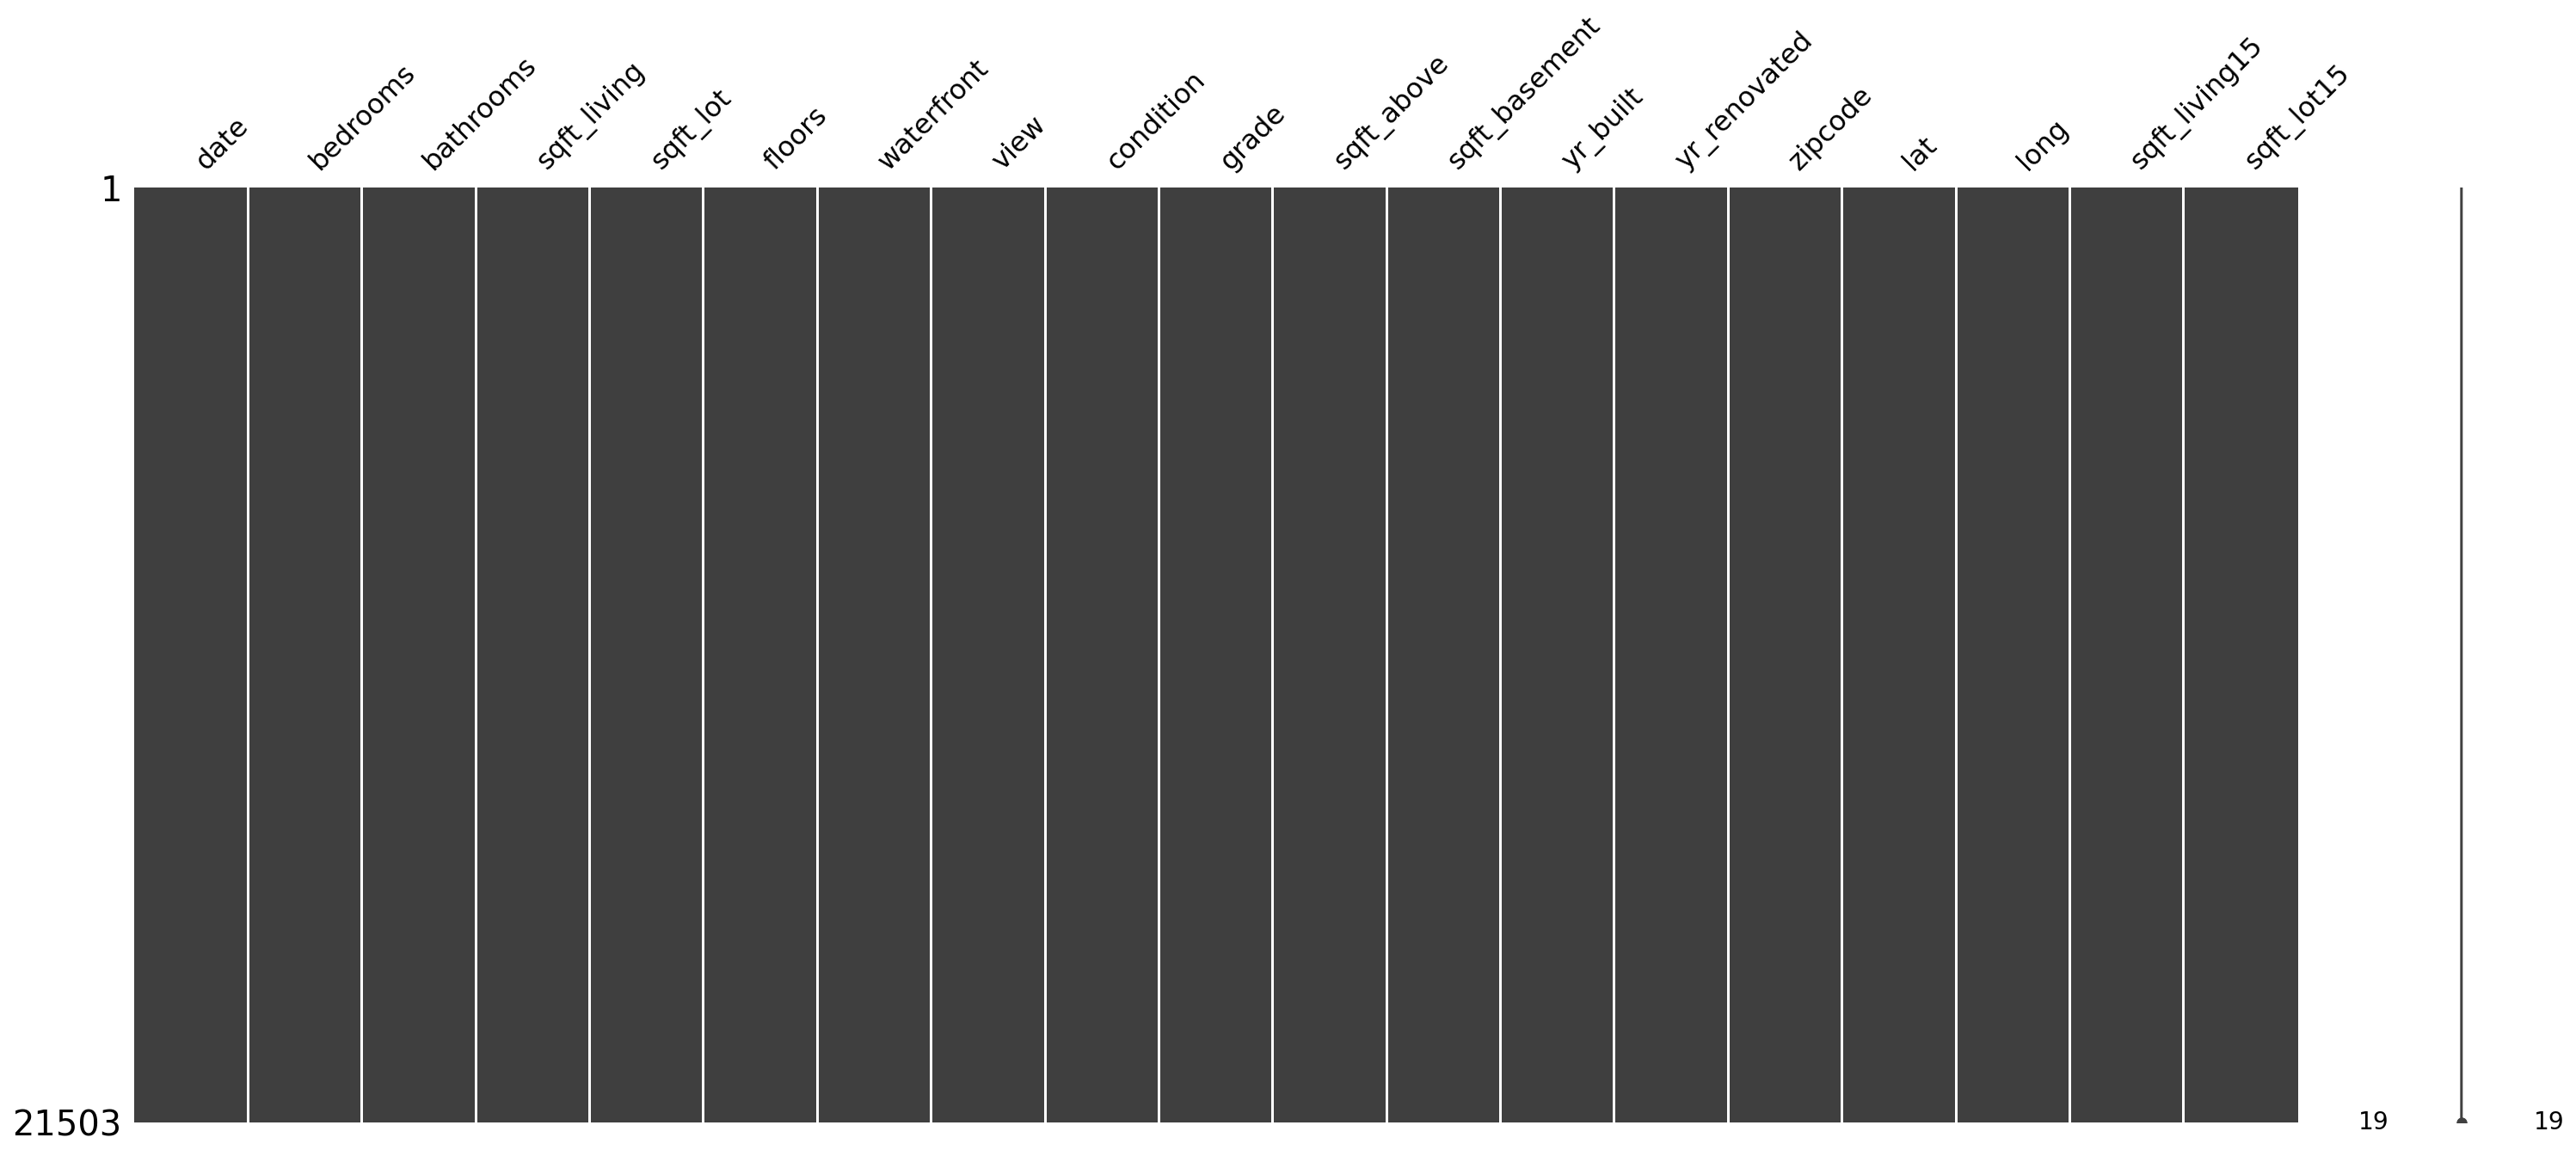

In [8]:
msno.matrix(data)

In [9]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2. 변수 재조합하기

#### 날짜데이터 년월 변환

In [10]:
data['date'] = data['date'].apply(lambda x : str(x[:8]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 침실 수와 화장실 수 합치기

In [11]:
data["bed_bath"] = data["bedrooms"] + data["bathrooms"]
data["bed_bath"] = data["bed_bath"].apply(lambda x : round(x))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4


#### 총 평방피트 만들기

In [12]:
data["sqft_total"] = data["sqft_above"] + data["sqft_basement"]
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,4,1180
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,3,770
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,5,1680
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,...,0,1995,0,98003,47.3097,-122.327,2238,6819,5,1715
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,...,0,1963,0,98198,47.4095,-122.315,1650,9711,4,1060


#### 재건축 연도 변수를 재건축 여부 변수로 변환

In [13]:
data["renovated_T/F"] = data["yr_renovated"].apply(lambda x: 1 if x > 0 else 0)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total,renovated_T/F
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,4,1180,0
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,2720,8062,3,770,0
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,1800,7503,5,1680,0
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,...,1995,0,98003,47.3097,-122.327,2238,6819,5,1715,0
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,...,1963,0,98198,47.4095,-122.315,1650,9711,4,1060,0


#### 부지와 주거공간 평방면적의 비율

In [14]:
data["sqft_ratio"] = data["sqft_living"] / data["sqft_lot"]
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total,renovated_T/F,sqft_ratio
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,1340,5650,4,1180,0,0.208850
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,2720,8062,3,770,0,0.077000
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,1800,7503,5,1680,0,0.207921
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,2238,6819,5,1715,0,0.251503
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,...,0,98198,47.4095,-122.315,1650,9711,4,1060,0,0.109155


### 3. 연속형 변수들은 표준화(Standard scaling)

In [15]:
scalling_columns = ["lat", "long", "sqft_living15", "sqft_lot15", "sqft_total", "sqft_ratio", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement"]
scaler = StandardScaler()

for columns in scalling_columns:
    data[columns] = scaler.fit_transform(data[columns].to_numpy().reshape(-1,1))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bed_bath,sqft_total,renovated_T/F,sqft_ratio
0,20141013,3,1.00,-0.981269,-0.228262,1.0,0,0,3,7,...,0,98178,-0.352932,-0.306853,-0.944103,-0.260644,4,-0.981269,0,-0.428725
1,20150225,2,1.00,-1.427577,-0.123379,1.0,0,0,3,6,...,0,98028,1.282568,-0.136435,1.068839,-0.172403,3,-1.427577,0,-0.919907
2,20150218,3,2.00,-0.436991,-0.169672,1.0,0,0,3,8,...,0,98074,0.408907,1.198507,-0.273122,-0.192854,5,-0.436991,0,-0.432185
3,20140627,3,2.25,-0.398892,-0.200076,2.0,0,0,3,7,...,0,98003,-1.806630,-0.803906,0.365768,-0.217877,5,-0.398892,0,-0.269827
4,20150115,3,1.50,-1.111896,-0.130347,1.0,0,0,3,7,...,0,98198,-1.086635,-0.718697,-0.491920,-0.112076,4,-1.111896,0,-0.800121


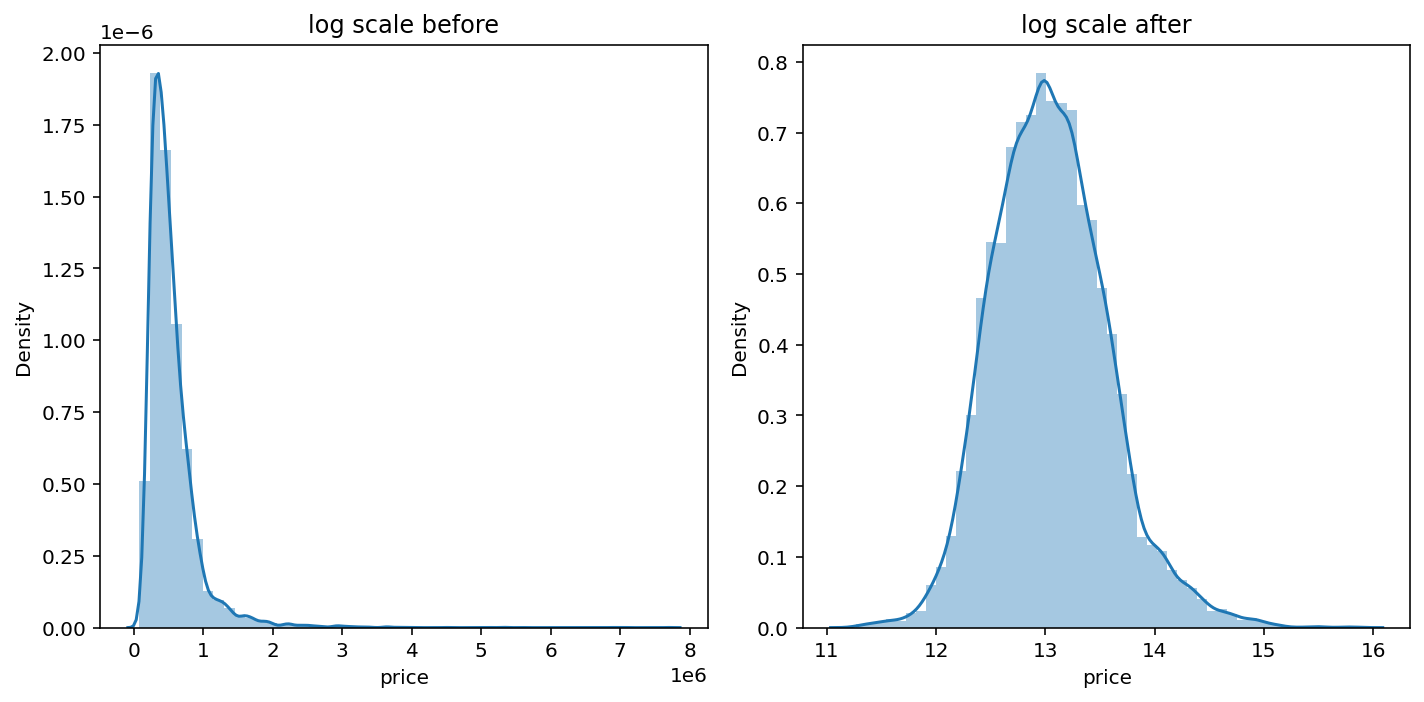

In [16]:
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = sns.distplot(y)
plt.title("log scale before")

fig.add_subplot(1,2,2)
res = sns.distplot(np.log1p(y))
plt.title("log scale after")

y = np.log1p(y)

plt.tight_layout()
plt.show()

위의 목적변수의 경우 첨도, 왜도도 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있었습니다. 저는 회귀모델을 사용할 것이기 때문에 Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어 주었습니다.

### 4. 변수간의 상관계수 시각화

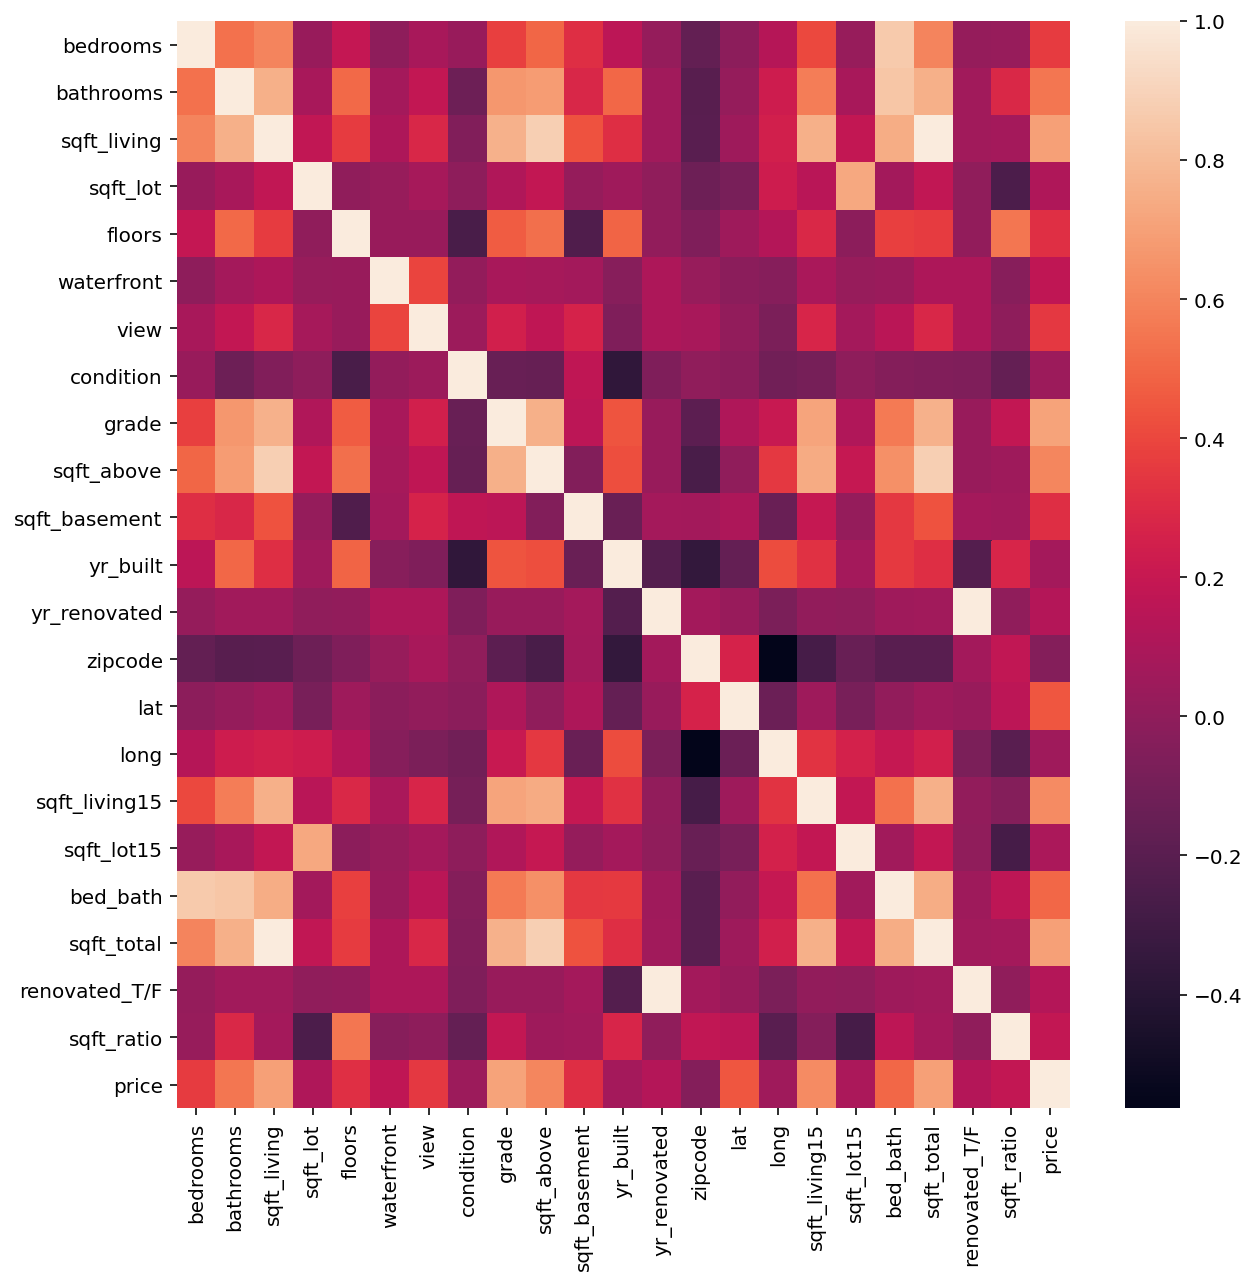

In [17]:
corr = pd.concat([data.iloc[:train_len,:], y], axis = 1)
plt.figure(figsize = (10, 10))
sns.heatmap(corr.corr())
plt.show()

종속 변수인 price와 다른 독립 변수들의 상관계수를 시각화하였더니 모든 독립변수에 어느정도 상관관계를 가지고 있는 것으로 보입니다.  
하지만 zipcode와 long의 상관계수가 -1에 가깝기 때문에 다중공선성 문제가 발생할 가능성이 있습니다.  
그리고 zipcode와 yr_built와 상관계수도 높습니다.

In [18]:
del data["zipcode"]

 zipcode 변수를 제거하여 다중공선성 문제를 조금이나마 해소시키겠습니다.

## 4. 모델 파이프라인 구축하기

In [19]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
print(x.shape)
print(sub.shape)

(15035, 22)
(6468, 22)


In [20]:
pipeline = Pipeline([
    ('model', 'passthrough')
])

params = [    
    {'model':(RandomForestRegressor(),),
     'model__n_estimators' : (250, 300)},
    
    {'model':(GradientBoostingRegressor(),),
     'model__n_estimators' : (250, 300)},
    
    {'model':(XGBRegressor(base_score = 0.5),)},
    
    {'model':(LGBMRegressor(),)}
]

In [21]:
grid_model = GridSearchCV(pipeline, params, scoring='neg_root_mean_squared_error',verbose = 3, cv = 3, n_jobs = 2)
grid_model.fit(x, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', 'passthrough')]),
             n_jobs=2,
             param_grid=[{'model': (RandomForestRegressor(),),
                          'model__n_estimators': (250, 300)},
                         {'model': (GradientBoostingRegressor(n_estimators=300),),
                          'model__n_estimators': (250, 300)},
                         {'model': (XGBRegressor(base_score=0.5, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsa...
                                                 max_depth=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=Non

## 5. 모델 성능 확인하기

In [22]:
grid_model.cv_results_

{'mean_fit_time': array([2.39956195e+01, 2.88180508e+01, 7.17733335e+00, 8.59661341e+00,
        5.48338890e-03, 7.48030345e-03]),
 'std_fit_time': array([0.03372955, 0.17057723, 0.00788002, 0.02777818, 0.00034259,
        0.00263101]),
 'mean_score_time': array([0.35510278, 0.4257412 , 0.02632499, 0.03290462, 0.        ,
        0.        ]),
 'std_score_time': array([0.00787801, 0.00453085, 0.00011015, 0.00571744, 0.        ,
        0.        ]),
 'param_model': masked_array(data=[RandomForestRegressor(), RandomForestRegressor(),
                    GradientBoostingRegressor(n_estimators=300),
                    GradientBoostingRegressor(n_estimators=300),
                    XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_ch

## 6. 완성된 결과 제출하기

In [23]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [24]:
y_pred = grid_model.predict(sub)
y_pred = np.expm1(y_pred)
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.326799e+05
1,15036,3.952897e+05
2,15037,1.325785e+06
3,15038,3.228917e+05
4,15039,3.213776e+05


In [25]:
my_submission_path = join(data_dir, 'submission2.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission2.csv
